In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install tensorflow

In [3]:
#!pip install intel-tensorflow

<h3>Enabling OneDNN Tensorflow Optimisations</h3>

In [4]:
!export TF_ENABLE_ONEDNN_OPTS=1

<h3>Importing Intel extensions for tensorflow</h3>

In [5]:
import intel_extension_for_tensorflow as itex

2023-07-14 07:58:03.264644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 07:58:34.953787: E itex/core/kernels/xpu_kernel.cc:38] XPU-GPU kernel not supported.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues


In [6]:
itex.set_backend('CPU')

In [7]:
# auto_mixed_precision_options = itex.AutoMixedPrecisionOptions()
# auto_mixed_precision_options.data_type = itex.FLOAT16

# graph_options = itex.GraphOptions(auto_mixed_precision_options=auto_mixed_precision_options)
# graph_options.auto_mixed_precision = itex.ON

# config = itex.ConfigProto(graph_options=graph_options)
# itex.set_config(config)

<h3>Importing the required Libraries</h3>

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt

<h3>Fasion MNIST Dataset is loaded from the Keras MNIST Library</h3>
<h3>The train dataset is then split into train and validiation sets</h3>

In [9]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels)

In [10]:
clothing = {0 : 'T-shirt',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

<h3>Visualising some sample Data</h3>

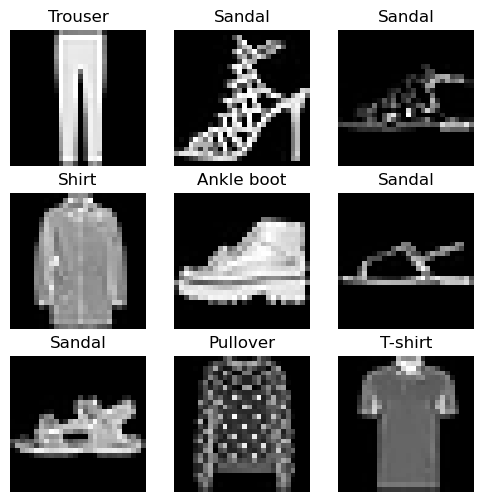

In [11]:
fig, axes = plt.subplots(3, 3, figsize = (6,6))
for row in axes:
    for axe in row:
        index = np.random.randint(train_images.shape[0])
        img = train_images[index].reshape(28,28)
        cloths = train_labels[index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()

<h3>Each class in training dataset have 4800 images</h3>

In [12]:
fasion_class, counts = np.unique(train_labels, return_counts=True)

result_counts = dict(zip(fasion_class, counts))

print(result_counts)

{0: 4800, 1: 4800, 2: 4800, 3: 4800, 4: 4800, 5: 4800, 6: 4800, 7: 4800, 8: 4800, 9: 4800}


<h3>Expanding Dimensions and Reshaping the Images</h3>

In [13]:
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))
val_images = val_images.reshape((-1, 28, 28, 1))

<h3>Data preprocessing by converting the image data to float32 data type and normalizing the pixel values to the range of [1, 0]</h3>


In [14]:
train_images = train_images.astype("float32")/255
test_images = test_images.astype("float32")/255
val_images = val_images.astype("float32")/255

<h3>Categorical Encoding the lables into 10 element Array</h3>

In [15]:
train_labels = to_categorical(train_labels, num_classes=10)
test_labels = to_categorical(test_labels, num_classes=10)
val_labels = to_categorical(val_labels, num_classes=10)

<h2>Defining the CNN model architecture with keras layers</h2>


In [55]:

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [56]:
# Compiling the model
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [57]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_30 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_31 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                      

<h2>Model is trained with a Batch size of 128 for 25 epochs with custom learning rate scheduler as callback</h2>
<h3>With the Intel extension for Tensorflow the training time is reduced to ~80% in CPU<h3>

In [58]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [59]:
history = model.fit(train_images, train_labels, batch_size = 128,
                              epochs = 25,verbose=2,
                              validation_data = (val_images, val_labels),
                              callbacks = [reduce_lr])

Epoch 1/25


2023-07-14 08:51:49.654036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:51:49.662202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:51:49.670036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:51:50.322477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:52:02.629274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:52:02.640279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:52:02.658848: I tensorflow/core/grappler/optimizers/cust

375/375 - 14s - loss: 0.9207 - accuracy: 0.7947 - val_loss: 2.3217 - val_accuracy: 0.4688 - lr: 0.0010 - 14s/epoch - 37ms/step
Epoch 2/25


2023-07-14 08:52:16.927906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:52:16.939629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:52:16.958347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.5030 - accuracy: 0.8693 - val_loss: 0.5321 - val_accuracy: 0.8435 - lr: 9.0000e-04 - 14s/epoch - 38ms/step
Epoch 3/25


2023-07-14 08:52:31.263204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:52:31.276661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:52:31.297449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.3840 - accuracy: 0.8870 - val_loss: 0.3161 - val_accuracy: 0.9076 - lr: 8.1000e-04 - 14s/epoch - 38ms/step
Epoch 4/25


2023-07-14 08:52:45.827667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:52:45.840498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:52:45.861213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 15s - loss: 0.3323 - accuracy: 0.8982 - val_loss: 0.3511 - val_accuracy: 0.8882 - lr: 7.2900e-04 - 15s/epoch - 39ms/step
Epoch 5/25


2023-07-14 08:53:00.343976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:00.356779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:00.377425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 15s - loss: 0.3019 - accuracy: 0.9047 - val_loss: 0.2826 - val_accuracy: 0.9135 - lr: 6.5610e-04 - 15s/epoch - 39ms/step
Epoch 6/25


2023-07-14 08:53:14.508894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:14.520842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:14.539504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.2879 - accuracy: 0.9103 - val_loss: 0.2689 - val_accuracy: 0.9149 - lr: 5.9049e-04 - 14s/epoch - 38ms/step
Epoch 7/25


2023-07-14 08:53:28.802105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:28.813962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:28.832756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.2699 - accuracy: 0.9143 - val_loss: 0.2903 - val_accuracy: 0.9053 - lr: 5.3144e-04 - 14s/epoch - 38ms/step
Epoch 8/25


2023-07-14 08:53:43.157682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:43.170120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:43.190745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.2547 - accuracy: 0.9201 - val_loss: 0.2499 - val_accuracy: 0.9210 - lr: 4.7830e-04 - 14s/epoch - 38ms/step
Epoch 9/25


2023-07-14 08:53:57.355037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:57.366680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:53:57.385403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.2445 - accuracy: 0.9225 - val_loss: 0.2369 - val_accuracy: 0.9270 - lr: 4.3047e-04 - 14s/epoch - 38ms/step
Epoch 10/25


2023-07-14 08:54:11.286492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:54:11.298169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:54:11.316908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.2317 - accuracy: 0.9288 - val_loss: 0.2331 - val_accuracy: 0.9285 - lr: 3.8742e-04 - 14s/epoch - 37ms/step
Epoch 11/25


2023-07-14 08:54:25.546423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:54:25.558156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:54:25.577076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.2229 - accuracy: 0.9293 - val_loss: 0.2254 - val_accuracy: 0.9293 - lr: 3.4868e-04 - 14s/epoch - 38ms/step
Epoch 12/25


2023-07-14 08:54:39.518214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:54:39.529637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:54:39.548190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.2099 - accuracy: 0.9348 - val_loss: 0.2346 - val_accuracy: 0.9296 - lr: 3.1381e-04 - 14s/epoch - 37ms/step
Epoch 13/25


2023-07-14 08:54:53.393345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:54:53.405082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:54:53.423729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.2059 - accuracy: 0.9348 - val_loss: 0.2232 - val_accuracy: 0.9311 - lr: 2.8243e-04 - 14s/epoch - 37ms/step
Epoch 14/25


2023-07-14 08:55:07.445031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:55:07.457025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:55:07.475929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1933 - accuracy: 0.9390 - val_loss: 0.2137 - val_accuracy: 0.9359 - lr: 2.5419e-04 - 14s/epoch - 37ms/step
Epoch 15/25


2023-07-14 08:55:21.508443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:55:21.520580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:55:21.539200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1872 - accuracy: 0.9409 - val_loss: 0.2143 - val_accuracy: 0.9359 - lr: 2.2877e-04 - 14s/epoch - 38ms/step
Epoch 16/25


2023-07-14 08:55:35.518676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:55:35.530696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:55:35.549509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1787 - accuracy: 0.9425 - val_loss: 0.2066 - val_accuracy: 0.9362 - lr: 2.0589e-04 - 14s/epoch - 37ms/step
Epoch 17/25


2023-07-14 08:55:49.611828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:55:49.624833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:55:49.645641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1729 - accuracy: 0.9454 - val_loss: 0.2026 - val_accuracy: 0.9403 - lr: 1.8530e-04 - 14s/epoch - 38ms/step
Epoch 18/25


2023-07-14 08:56:03.727201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:56:03.738984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:56:03.757715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1673 - accuracy: 0.9481 - val_loss: 0.2056 - val_accuracy: 0.9366 - lr: 1.6677e-04 - 14s/epoch - 38ms/step
Epoch 19/25


2023-07-14 08:56:17.822676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:56:17.834252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:56:17.853143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1596 - accuracy: 0.9496 - val_loss: 0.2045 - val_accuracy: 0.9383 - lr: 1.5009e-04 - 14s/epoch - 38ms/step
Epoch 20/25


2023-07-14 08:56:31.978654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:56:31.990335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:56:32.008941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1543 - accuracy: 0.9518 - val_loss: 0.2026 - val_accuracy: 0.9392 - lr: 1.3509e-04 - 14s/epoch - 38ms/step
Epoch 21/25


2023-07-14 08:56:45.954489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:56:45.967402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:56:45.988205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1473 - accuracy: 0.9537 - val_loss: 0.2152 - val_accuracy: 0.9361 - lr: 1.2158e-04 - 14s/epoch - 37ms/step
Epoch 22/25


2023-07-14 08:57:00.264211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:57:00.275876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:57:00.294650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1452 - accuracy: 0.9546 - val_loss: 0.2003 - val_accuracy: 0.9394 - lr: 1.0942e-04 - 14s/epoch - 38ms/step
Epoch 23/25


2023-07-14 08:57:14.434846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:57:14.447397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:57:14.468047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1397 - accuracy: 0.9566 - val_loss: 0.2003 - val_accuracy: 0.9400 - lr: 9.8477e-05 - 14s/epoch - 38ms/step
Epoch 24/25


2023-07-14 08:57:28.700707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:57:28.713993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:57:28.734801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1376 - accuracy: 0.9572 - val_loss: 0.2011 - val_accuracy: 0.9380 - lr: 8.8629e-05 - 14s/epoch - 38ms/step
Epoch 25/25


2023-07-14 08:57:42.812759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:57:42.825018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:57:42.843935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


375/375 - 14s - loss: 0.1322 - accuracy: 0.9580 - val_loss: 0.1996 - val_accuracy: 0.9397 - lr: 7.9766e-05 - 14s/epoch - 38ms/step


<h3>The model is tested against test dataset</h3>
<h3>An Accuracy of 93.6% is observed</h3>

In [60]:
score = model.evaluate(test_images, test_labels)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

 40/313 [==>...........................] - ETA: 1s - loss: 0.1985 - accuracy: 0.9414

2023-07-14 08:58:12.523617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:58:12.530958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:58:12.542504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


313/313 [==============================] - 1s 4ms/step - loss: 0.2109 - accuracy: 0.9363
Loss: 0.2109
Accuracy: 0.9363


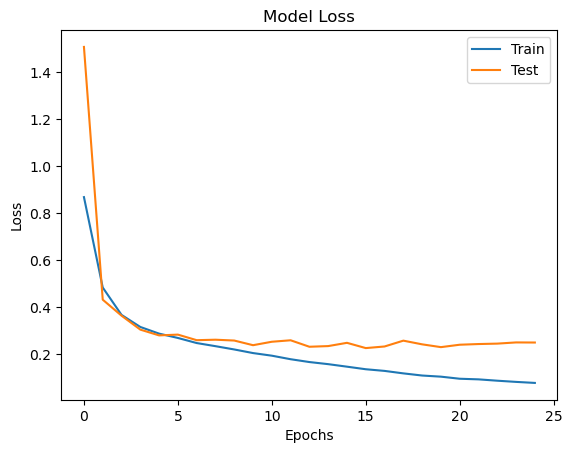

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

<h2>The Learning curves shows that the model is not overfitting </h2>

* Training loss and validation loss are close 
* Training Accuracy and validation accuracy are close

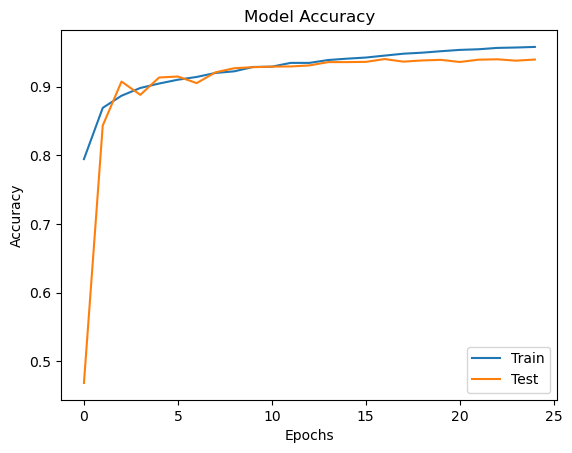

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [62]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


<h2> Plotting Confusion Matrix to evaluate model performance</h2>

  1/313 [..............................] - ETA: 49s

2023-07-14 08:58:48.519419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:58:48.527089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:58:48.539011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-14 08:58:48.603203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


313/313 [==============================] - 1s 3ms/step


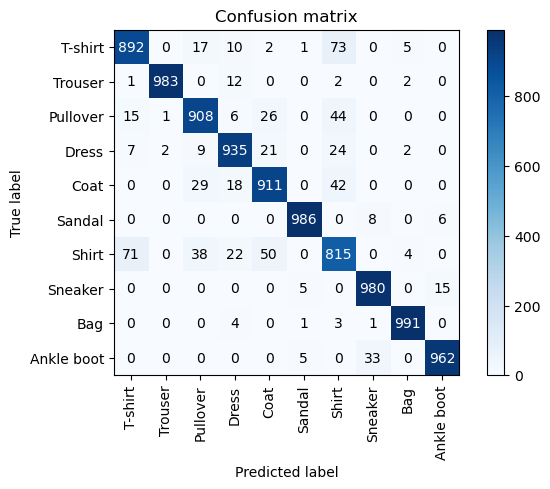

In [63]:
Y_pred = model.predict(test_images)

Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(test_labels,axis = 1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx,
            classes = clothing.values())

<h4>Sample of correctly predicted images</h4>

In [64]:
correct = []
for i in range(len(test_labels)):
    if(Y_pred_classes[i] == Y_true[i]):
        correct.append(i)
    if(len(correct) == 4):
        break

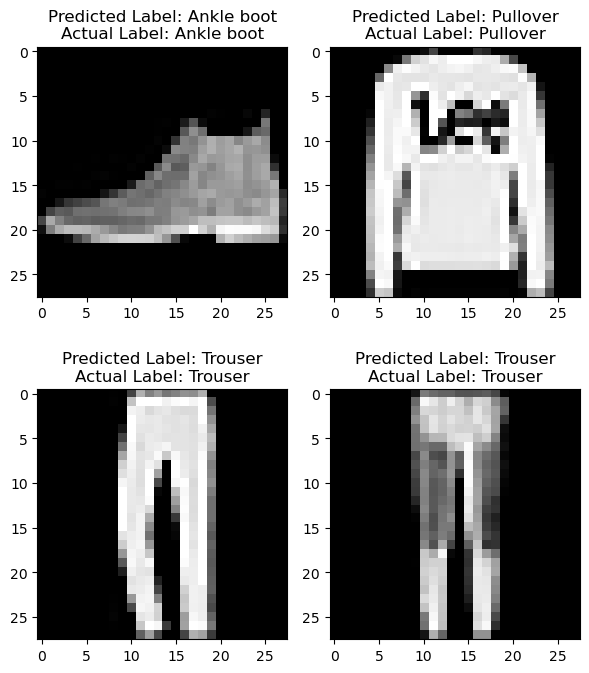

In [65]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(6, 7)
for i, axi in enumerate(ax.flat):
    axi.imshow(test_images[correct[i]].reshape(28, 28), cmap='gray')
    axi.set_title("Predicted Label: " + str(clothing[Y_pred_classes[correct[i]]]) + "\n"
                  + "Actual Label: " + str(clothing[Y_true[correct[i]]]))

plt.tight_layout()
plt.show()

<h4>Sample of incorrectly predicted images</h4>

In [66]:
incorrect = []
for i in range(len(test_labels)):
    if(not Y_pred_classes[i] == Y_true[i]):
        incorrect.append(i)
    if(len(incorrect) == 4):
        break

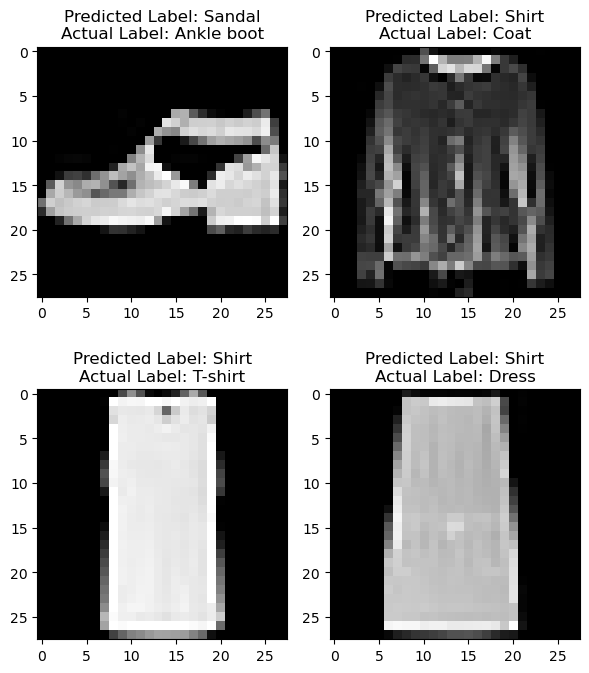

In [67]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(6, 7)

for i, axi in enumerate(ax.flat):
    axi.imshow(test_images[incorrect[i]].reshape(28, 28), cmap='gray')
    axi.set_title("Predicted Label: " + str(clothing[Y_pred_classes[incorrect[i]]]) + "\n"
                  + "Actual Label: " + str(clothing[Y_true[incorrect[i]]]))

plt.tight_layout()
plt.show()


<h2>Classification Report</h2>

In [68]:
print(classification_report(Y_true, Y_pred_classes, target_names = clothing.values()))

              precision    recall  f1-score   support

     T-shirt       0.90      0.89      0.90      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.91      0.91      0.91      1000
       Dress       0.93      0.94      0.93      1000
        Coat       0.90      0.91      0.91      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.81      0.81      0.81      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



<h2>Model is saved for inference later</h2>

In [69]:
model.save("../models/itex_model.h5")

In [70]:
tf.saved_model.save(model, '../models/itex_saved_model')

2023-07-14 08:59:14.248532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,12,12,32]
	 [[{{node inputs}}]]
2023-07-14 08:59:14.265611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,4,4,64]
	 [[{{node inputs}}]]
2023-07-14 08:59:14.279322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2023-07-

INFO:tensorflow:Assets written to: ../models/itex_saved_model/assets


2023-07-14 08:59:15,939 - tensorflow - INFO - Assets written to: ../models/itex_saved_model/assets
